In [1]:
# general imports
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.general_helper import *
from helper.preprocess import *
from custom_recommender import *

# keras
from keras import Input, Model
from keras.layers import Embedding, Reshape, Dot


# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\walke\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [82]:
df = pd.read_csv('../../merged_df.csv')

df = df[df['title'].notna()]

customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))

In [83]:
# select test size
n = 39601

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

# split into train and test set
df_train = df[:-n]
df_test = df[-n:]

#### Predicting rating based on mean category

In [84]:
total_mean = df.overall.mean()

In [85]:
# fill nan categories
df_train[['categories']] = df_train[['categories']].fillna(value='unspecified')

# populate dictionary with cataegory and mean product rating
cat_rating_dict = dict(df_train.groupby('categories').mean()['overall'])

# apply the ratings to categories
df_train['cat_rat'] = df_train['categories'].apply(lambda x: cat_rating_dict[x])


# fill asin dict with asin and rating
asin_rating_dict = dict(df_train.groupby('asin').mean()['cat_rat'])

# apply rating per asin
df_train['asin_rating'] = df_train['asin'].apply(lambda x: asin_rating_dict[x])


# select testing dataframe
x = df_train[['reviewerID', 'overall', 'asin_rating']]

# calculate loss
rmse = np.sqrt(mean_squared_error(x['overall'], x['asin_rating']))
rmse

1.016784776646624

In [86]:
test = df_test[['reviewerID', 'overall', 'asin']]
test['asin_rating'] = test['asin'].apply(lambda x: asin_rating_dict.get(x, total_mean))

rmse = np.sqrt(mean_squared_error(test['overall'], test['asin_rating']))
rmse

1.0202247398569801

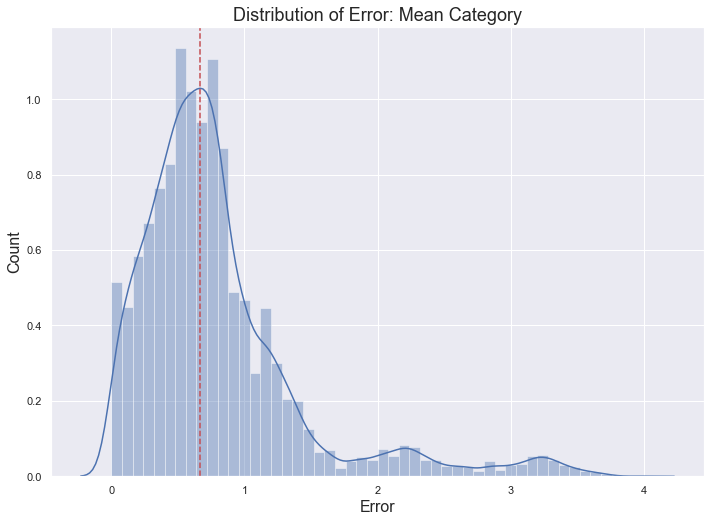

In [87]:
# lets look at the distribution of error
error = abs(test['overall'] - test['asin_rating'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Mean Category', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/mean_categories_error");

#### Rating prediction based on mean product rating

In [79]:
# populate dictionary with cataegory and mean product rating
asin_rating_dict = dict(df_train.groupby('asin').mean()['overall'])

# apply the ratings to categories
df_train['asin_rating'] = df_train['asin'].apply(lambda x: asin_rating_dict[x])

# select testing dataframe
x = df_train[['reviewerID', 'overall', 'asin_rating']]

# calculate loss
rmse = np.sqrt(mean_squared_error(x['overall'], x['asin_rating']))
rmse

0.9368504753273041

In [80]:
test = df_test[['reviewerID', 'overall', 'asin']]
test['asin_rating'] = test['asin'].apply(lambda x: asin_rating_dict.get(x, total_mean))

rmse = np.sqrt(mean_squared_error(test['overall'], test['asin_rating']))
rmse

1.0026359910867242

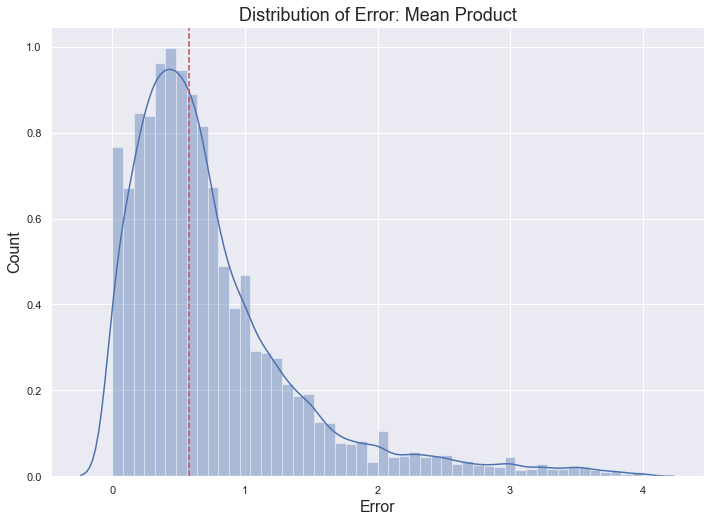

In [81]:
# lets look at the distribution of error
error = abs(test['overall'] - test['asin_rating'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Mean Product', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/mean_categories_error");

In [32]:
# set meta dataframe for reference later
meta = df[['reviewerID', 'asin', 'overall', 'title']]

In [6]:
# select test size
n = 39601

# shuffle dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# split into train and test set
df_train = df[:-n]
df_test = df[-n:]

##### train test split and set pivot table 

In [7]:
# create pivot table for correct reviewers and products
pivot_df = df_train.pivot_table(index='reviewerID', columns='asin', values='overall')

In [56]:
x = pivot_df.fillna(0).to_numpy()

In [63]:
x[x[:, 0] != 0].shape

(7, 4335)

In [62]:
x.shape

(8612, 4335)

In [54]:
df.groupby('asin').count().sort_values(by='reviewerID', ascending=False)['reviewerID'].index[0]

'B0037KMI0U'

#### Recomender based on weighted averages
* This will be the baseline predictive model

In [10]:
# https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website
# min number of votes for weight (regularization)
M = 50

# mean ratings of all products
C = pivot_df.stack().mean()

# mean rating per product
R = pivot_df.mean(axis=0).values

# rating cout for all products
V = pivot_df.count().values


weighted_score = (V / (V + M) * R) + (M / (V + M) * C) 

In [11]:
weighted_rankings = np.argsort(weighted_score)[::-1]
weighted_rankings

array([1184, 3998, 2890, ..., 3637,  725, 2463], dtype=int64)

In [12]:
weighted_score = np.sort(weighted_score)[::-1]
weighted_score

array([4.63898836, 4.60118654, 4.5761371 , ..., 3.40779329, 3.34441083,
       3.24704889])

In [13]:
weighted_product_ids = pivot_df.columns[weighted_rankings]

In [14]:
df_preds = df_test.set_index('asin').join(pd.DataFrame(
    weighted_score, index=weighted_product_ids , columns=['Prediction'])
                                         )[['overall', 'Prediction']]

In [15]:
df_preds

,overall,Prediction
asin,,
159985130X,5.0,4.192346
159985130X,5.0,4.192346
7884890364,4.0,4.344202
7884890364,5.0,4.344202
7884890364,5.0,4.344202
...,...,...
B00L1H4I0Y,5.0,4.390058
B00LFB2ENY,5.0,4.366062
B00LIASY0Y,5.0,4.317632


In [16]:
y_true = df_preds['overall']
y_pred = df_preds['Prediction']

y_pred.fillna(value=1, inplace=True)

In [17]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

1.0065541170737398

Text(0, 0.5, 'Count')

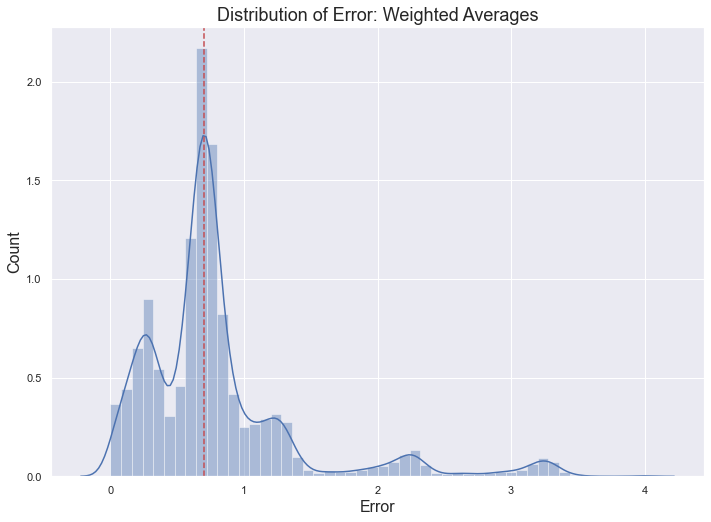

In [20]:
# lets look at the distribution of error
error = abs(df_preds['overall'] - df_preds['Prediction'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Weighted Averages', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/weighted_average_error");

##### Random Forest Recommender

In [25]:
df = pd.read_csv('../../merged_df.csv')

In [26]:
df = df[df['title'].notna()]

# select reviewer and product values
customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))

In [27]:
model = custom_predictor(df)

In [28]:
model.fit(text_columns = ['summary'])

In [29]:
df.asin.unique()

array(['159985130X', 'B00027CBTY', 'B00028MKRQ', ..., 'B00IT40BDA',
       'B00JTHUQ3Q', 'B00LIASY0Y'], dtype=object)

In [66]:
import time

start = time.time()
model.predict_one(model = RandomForestRegressor(), product='159985130X')
end = time.time()
print(end - start)

0.3569666666666664
3.888715982437134


In [67]:
import time

start = time.time()
model.predict_one_eff(model = RandomForestRegressor(), product='159985130X')
end = time.time()
print(end - start)

1.481966666666666
3.670189142227173


In [38]:
preds = model.predict_one(model = RandomForestRegressor(), product='159985130X')

0.6516666666666667


In [41]:
import timeit
print(timeit.timeit(model.predict_one(model = RandomForestRegressor(), product='159985130X')))

0.6144999999999999


ValueError: stmt is neither a string nor callable

In [39]:
preds

defaultdict(int,
            {'159985130X': array([3.75, 4.48, 3.87, ..., 3.53, 3.63, 3.58])})

In [ ]:
'DONE'

In [40]:
preds = model.predict_all(model = RandomForestRegressor())

KeyboardInterrupt: 